In [25]:
import pandas as pd
import numpy as np
import numpy.random as nr

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn import linear_model
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC

import sklearn.metrics as sklm
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, mean_squared_error
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler

import scipy.stats as ss
from scipy.stats import boxcox, norm, skew
from scipy.special import boxcox1p


import math
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

import warnings as wrn
wrn.filterwarnings('ignore', category = DeprecationWarning) 
wrn.filterwarnings('ignore', category = FutureWarning) 
wrn.filterwarnings('ignore', category = UserWarning)

%matplotlib inline

In [2]:
## reading and observing the data

test=pd.read_csv('test.csv')
train=pd.read_csv('train.csv')
test.name ='Testing Data'
train.name = 'Training Data'

merged = pd.concat([train,test], axis = 0, sort=True)
merged['LogSalePrice'] = np.log(merged['SalePrice'])  # we see later taking log gives more linear relationship

num_merged = merged.select_dtypes(include=np.number)
cat_merged = merged.select_dtypes(include ='object')

print('Shape of training data: ', train.shape)
print ('Shape of testing data: ', test.shape)
print('Shape of merged data:', merged.shape)
# print(train.head())
print(merged.select_dtypes(include=np.number).columns.values)

Shape of training data:  (1460, 81)
Shape of testing data:  (1459, 80)
Shape of merged data: (2919, 82)
['1stFlrSF' '2ndFlrSF' '3SsnPorch' 'BedroomAbvGr' 'BsmtFinSF1'
 'BsmtFinSF2' 'BsmtFullBath' 'BsmtHalfBath' 'BsmtUnfSF' 'EnclosedPorch'
 'Fireplaces' 'FullBath' 'GarageArea' 'GarageCars' 'GarageYrBlt'
 'GrLivArea' 'HalfBath' 'Id' 'KitchenAbvGr' 'LotArea' 'LotFrontage'
 'LowQualFinSF' 'MSSubClass' 'MasVnrArea' 'MiscVal' 'MoSold' 'OpenPorchSF'
 'OverallCond' 'OverallQual' 'PoolArea' 'SalePrice' 'ScreenPorch'
 'TotRmsAbvGrd' 'TotalBsmtSF' 'WoodDeckSF' 'YearBuilt' 'YearRemodAdd'
 'YrSold' 'LogSalePrice']


C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0, 0.5, 'Frequency of Price')

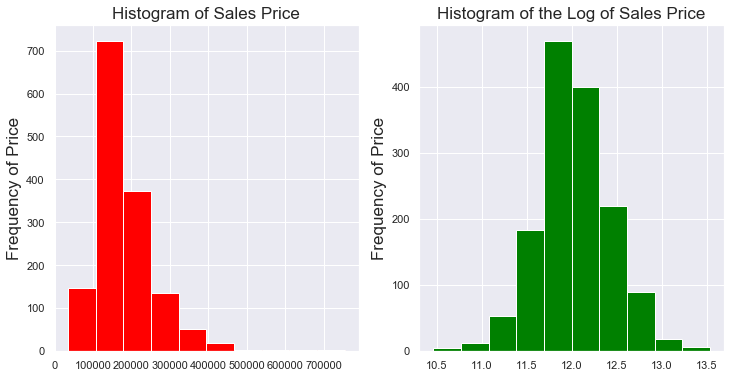

In [3]:
# visulazing the data
fig = plt.figure( figsize = (12,6))
plt.subplot(1,2,1)
plt.hist(merged.SalePrice, color='red')
plt.title('Histogram of Sales Price', fontsize = 17)
plt.ylabel('Frequency of Price', fontsize = 17)

# hist of log of Sale Price
plt.subplot(1,2,2)
plt.hist(np.log(merged.SalePrice), color='green')
plt.title('Histogram of the Log of Sales Price', fontsize = 17)
plt.ylabel('Frequency of Price', fontsize = 17)


(2919, 39)


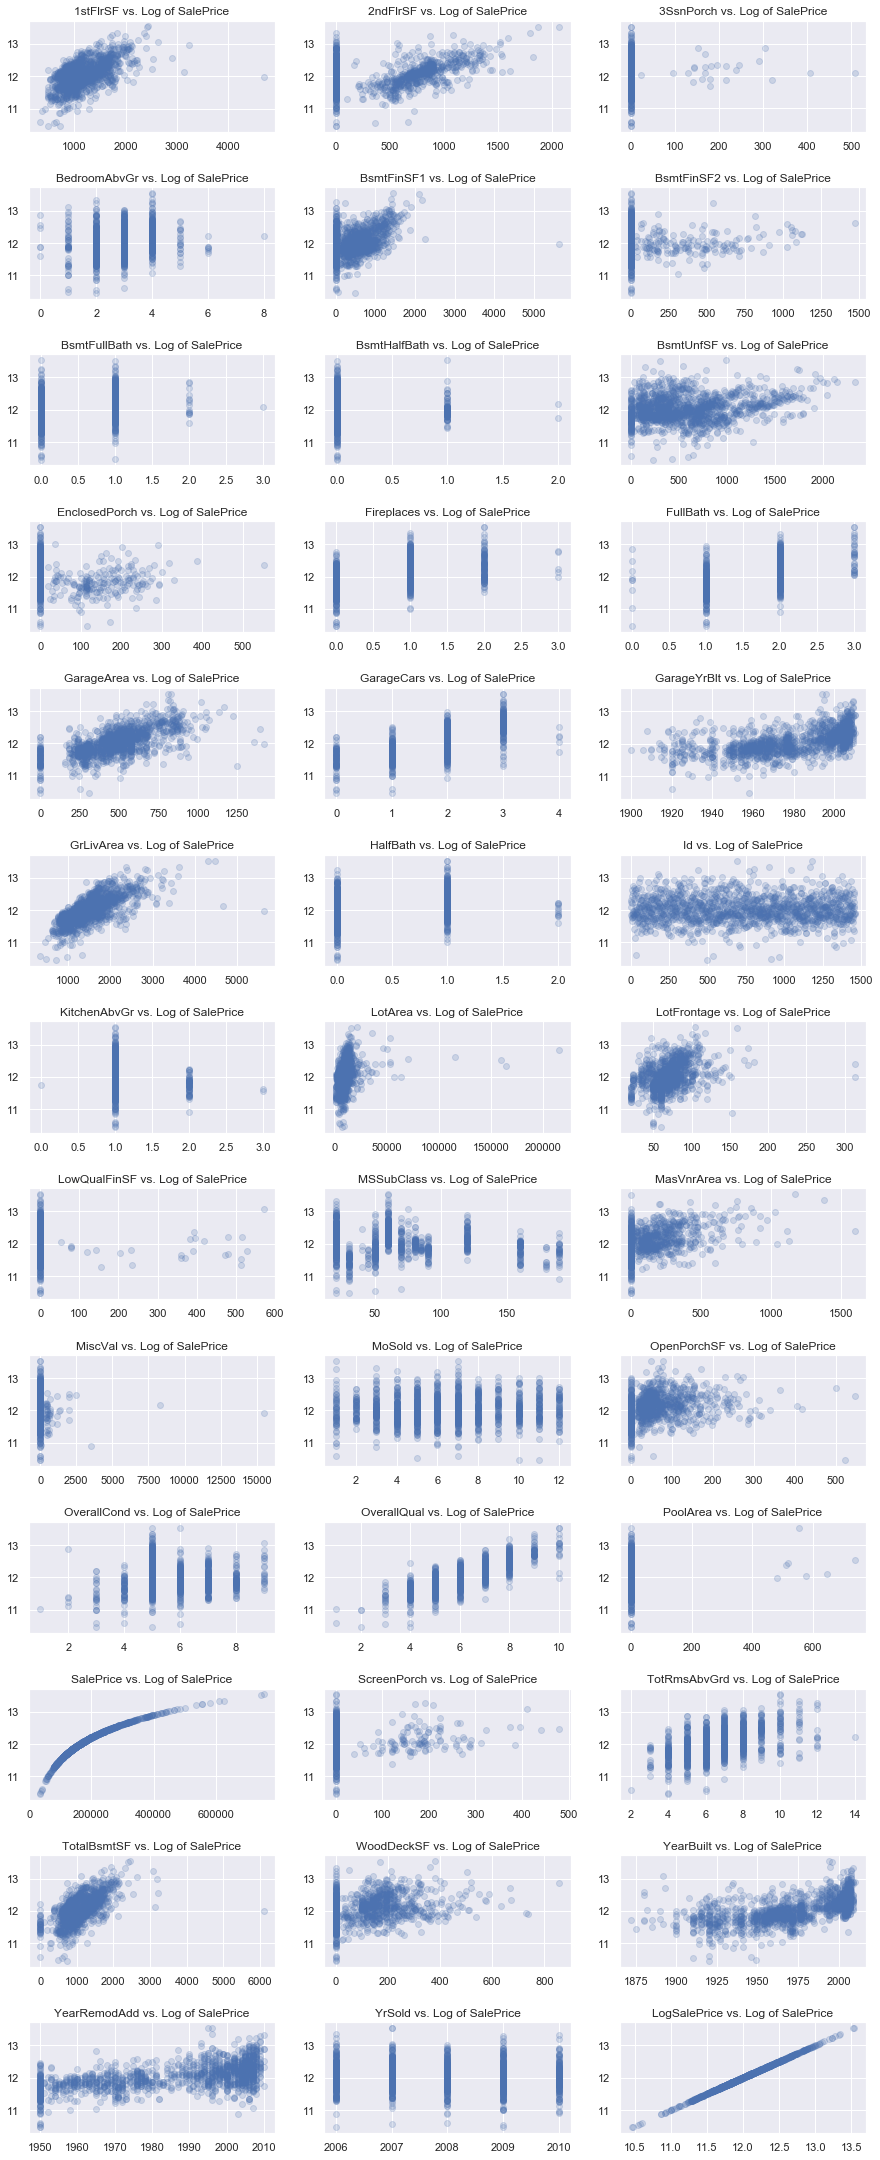

In [4]:
# Function for creating scatter of numerical categories vs price
print(num_merged.shape)

def scatter_plot(df, variables, n_cols, n_rows):
    fig = plt.figure(figsize = (15, 45))
    for i, var_name in enumerate(variables):
        # print(var_name)
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        plt.scatter(x=df[var_name], y=num_merged['LogSalePrice'], alpha =.2)
        plt.subplots_adjust(hspace = .5)
        ax.set_title('{} vs. Log of SalePrice'.format(var_name))
scatter_plot(merged, num_merged, 3,15 )

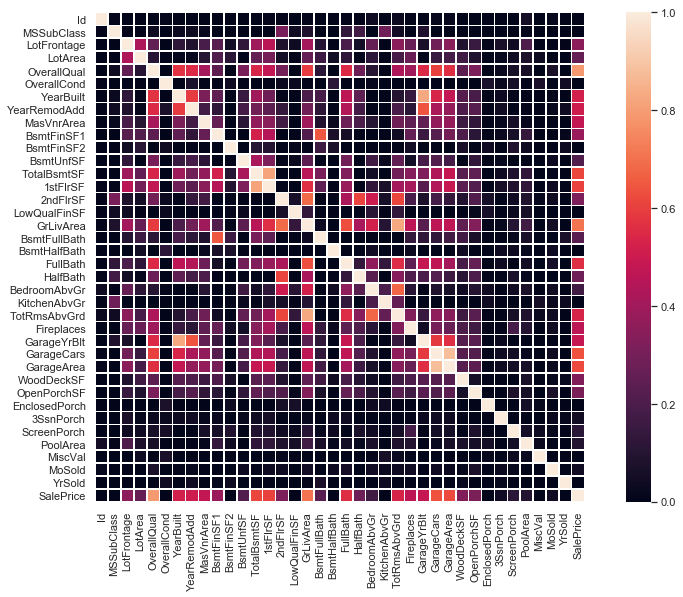

In [5]:
## we can see linear relationships in scatters above the ones that are are verticle should be categorized as categorical
## looking at the correlation matrix

corr = train.corr()
fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(corr, linewidths=.5, vmin=0, vmax=1, square=True)

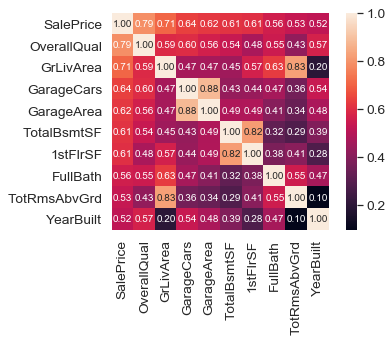

In [6]:
## we can make a more consise corr matrix based on sales price

k = 10 #number of variables for heatmap
cols = corr.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

From looking at heat map we see the top 10 correlations to Sale Pirce
further observation show GarageCars and GarageArea are closesly correlated and logically
that makes sense. large number cars more likely to have larger garage area so we can ommit it


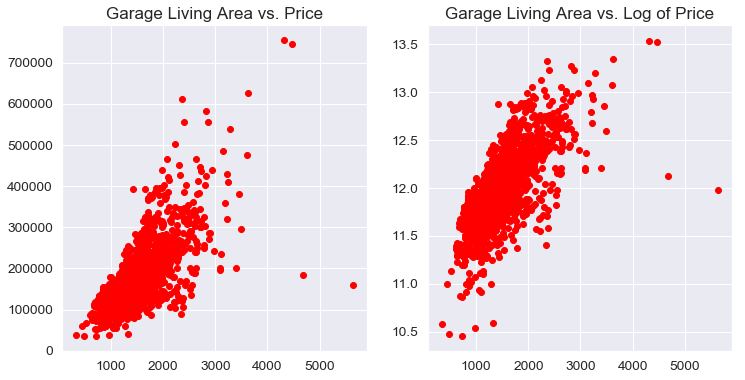

In [8]:
# further observation of data to spot outliers

## From observing data taking the log of sales prics provides more normal distribution
def scatter_plot(x,y, Title, font_size, color):
        
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,6))
    ax1.scatter(x, y, c=color)
    ax2.scatter(x, np.log(y), c=color)
    ax1.set_title(Title, fontsize = int(font_size))
    ax2.set_title('Garage Living Area vs. Log of Price', fontsize = 17)
    plt.show()
scatter_plot(merged['GrLivArea'], merged['SalePrice'], 'Garage Living Area vs. Price', 17, 'red')

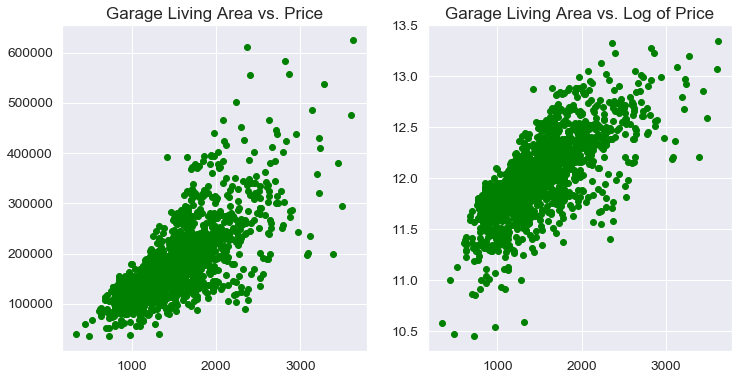

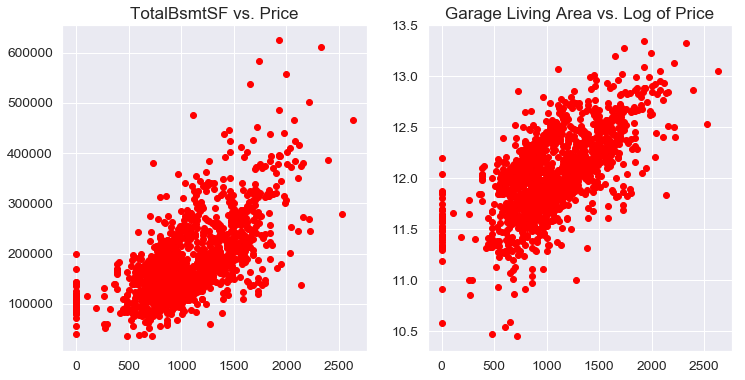

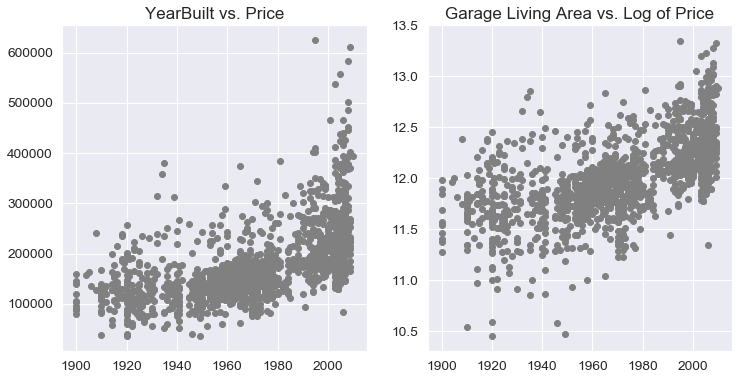

In [9]:
## dropping outliers from scatter plots above 

train.drop(train[train['GrLivArea']>4000].index, inplace=True)
train.reset_index(drop = True, inplace = True)
scatter_plot(train['GrLivArea'], train['SalePrice'], 'Garage Living Area vs. Price', 17, 'green')

train.drop(train[train['TotalBsmtSF']>3000].index, inplace=True)
train.reset_index(drop = True, inplace = True)
scatter_plot(train['TotalBsmtSF'], train['SalePrice'], 'TotalBsmtSF vs. Price', 17, 'red')

train.drop(train[train['YearBuilt']<1900].index, inplace=True)
train.reset_index(drop = True, inplace = True)
scatter_plot(train['YearBuilt'], train['SalePrice'], 'YearBuilt vs. Price', 17, 'grey')

y_train = train['SalePrice']


(2897, 80)
There are 34 features with missing falues


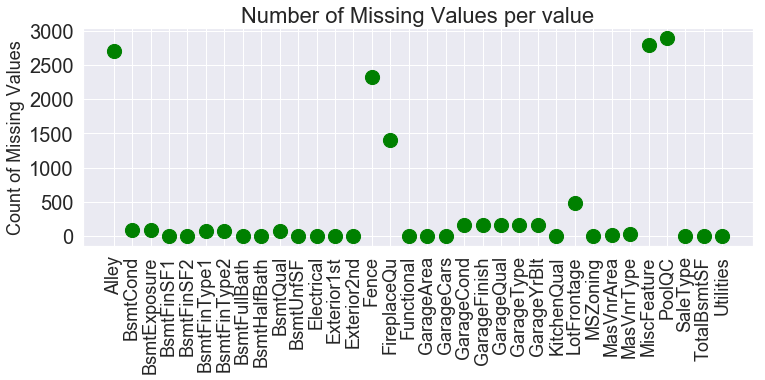

In [10]:
## imputing missing variables
## for categorical variables mode-imputation is performed 
## for numerical variable is usually mean-imputation when symmetric, and median for for skewed 

for col in train.columns:
    if 'SalePrice'in col:
        train.drop('SalePrice', axis = 1, inplace=True)
    else: 
        train = train
    
merged = pd.concat([train, test], axis = 0, sort =True)

## print(train.shape)
## print(test.shape)
print(merged.shape)

merged.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']] = merged.loc[:,['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold', 'YrSold']].astype('object')

## columns with missing numbers
missing_cols = merged.columns[merged.isnull().any()].values
print('There are {} features with missing falues'.format(missing_cols.shape[0]))
rotation = 90
## plot of missing features and their missing values 
missing_col_val = len(merged)-merged.loc[:, np.sum(merged.isnull())>0].count()
x = missing_col_val.index
y = missing_col_val
title = 'Variables with Missing Values'
fig, ax=plt.subplots(figsize=(12,4))
plt.yticks(fontsize=20)
plt.xticks(rotation=90, fontsize=18)
ax.scatter(x,y,s=200,c='green')
ax.set_title('Number of Missing Values per value', fontsize=22)
ax.set_ylabel('Count of Missing Values', fontsize =18)
plt.show()

In [11]:
[print('Percentage of missing values: \n\n',(missing_col_val/(merged.shape[0])*100)
    .sort_values(ascending=False))
]
'''
## looking at missing values we usually drop cols with large ammounts 
of missing data, however from data description we can treat many columns 
as 0 or none instead of NaN. '''

## imputing (filling in) None for NaN
none_cols = merged[['PoolQC','MiscFeature','Alley', 'Fence', 'FireplaceQu', 
                    'GarageType', 'GarageCond','GarageFinish','GarageQual',
                    'BsmtFinType2','BsmtExposure','BsmtQual','BsmtCond','BsmtFinType1','MasVnrType']]

for i in none_cols.columns:
    merged[i].fillna('None', inplace=True)
    
## imputing categorical null cols for the mode
mode_cols = merged[['Electrical', 'MSZoning','Utilities','Exterior1st',
                    'Exterior2nd','KitchenQual','Functional', 'SaleType']]

for i in mode_cols.columns:
    merged[i].fillna(merged[i].mode()[0], inplace = True)

## imputing discrete or continuous numerical variables by their medians
median_cols = merged[['BsmtFullBath','BsmtHalfBath', 'GarageCars', 'MasVnrArea',
                      'GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'GarageArea']]

for i in median_cols.columns:
    merged[i].fillna(merged[i].median(), inplace = True)

Percentage of missing values: 

 PoolQC          99.723852
MiscFeature     96.410079
Alley           93.372454
Fence           80.462547
FireplaceQu     48.671039
LotFrontage     16.741457
GarageQual       5.419399
GarageCond       5.419399
GarageFinish     5.419399
GarageYrBlt      5.419399
GarageType       5.350362
BsmtExposure     2.830514
BsmtCond         2.830514
BsmtQual         2.795996
BsmtFinType1     2.726959
BsmtFinType2     2.726959
MasVnrType       0.828443
MasVnrArea       0.793925
MSZoning         0.138074
BsmtFullBath     0.069037
BsmtHalfBath     0.069037
Utilities        0.069037
Functional       0.069037
Electrical       0.034518
BsmtUnfSF        0.034518
Exterior1st      0.034518
Exterior2nd      0.034518
TotalBsmtSF      0.034518
GarageArea       0.034518
GarageCars       0.034518
BsmtFinSF2       0.034518
BsmtFinSF1       0.034518
KitchenQual      0.034518
SaleType         0.034518
dtype: float64


In [12]:
## viewing merged df after dealing with most missing values
missing_col_val = len(merged)-merged.loc[:, np.sum(merged.isnull())>0].count()
[
print('Percentage of missing values: \n\n',(missing_col_val/(merged.shape[0])*100)
    .sort_values(ascending=False))
]

## since missing % is close to 15 we will impute by median grouped by some other variable 
## we need convert categorical var into numerical
df = merged.drop(['Id', 'LotFrontage'], axis=1)
le = LabelEncoder()
df = df.apply(le.fit_transform)
df.head(3)

## Inserting LotFrontage and setting it as index
df['LotFrontage'] = merged['LotFrontage']
df = df.set_index('LotFrontage').reset_index()
df.head(3)


## correlation of df
corr = df.corr()
display(corr['LotFrontage'].sort_values(ascending = False)[:5])
display(corr['LotFrontage'].sort_values(ascending = False)[-5:])

## since BldgType is most neg correlated we will impute median with groupby using BldgType

merged['LotFrontage'] = merged.groupby(['BldgType'])['LotFrontage'].transform(lambda x:x.fillna(x.median()))
print('Missing variables left ', merged.columns[merged.isna().any()].values)

Percentage of missing values: 

 LotFrontage    16.741457
dtype: float64


LotFrontage    1.000000
LotArea        0.639965
1stFlrSF       0.420257
GarageArea     0.360497
GrLivArea      0.347875
Name: LotFrontage, dtype: float64

LotConfig    -0.191054
GarageType   -0.295651
MSSubClass   -0.398100
BldgType     -0.486039
Utilities          NaN
Name: LotFrontage, dtype: float64

Missing variables left  []


In [13]:
'''
## Dealing with Skewedness of Distributions 
## We already know our target (SalePrice is Skewed, we can account for that,
and other skewed variables)
'''
def hist_plot(x, title, xlabel, ylabel):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.hist(x, bins= 20, color ='orange')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

plt.show()


In [14]:
'''
## For loop for plotting mult hist of variables not done yet


def hist_plots(df, variables, n_cols, n_rows):
    for i, var_name in enumerate(variables[:3]):
        plt.figure(figsize=(15,5))
        # print(var_name)
        plt.subplot(121)
        plt.hist(x=df[var_name], bins=20,)
        plt.subplots_adjust(hspace = .5)
        
        plt.subplot(122)
        plt.hist(x=np.log(df[var_name]>0), bins = 20)

num_vars = merged.select_dtypes(include = np.number).astype('float64')
variables = num_vars.columns.values
print(num_vars.dtypes)
hist_plots(merged, variables, 5 ,5)'''

"\n## For loop for plotting mult hist of variables not done yet\n\n\ndef hist_plots(df, variables, n_cols, n_rows):\n    for i, var_name in enumerate(variables[:3]):\n        plt.figure(figsize=(15,5))\n        # print(var_name)\n        plt.subplot(121)\n        plt.hist(x=df[var_name], bins=20,)\n        plt.subplots_adjust(hspace = .5)\n        \n        plt.subplot(122)\n        plt.hist(x=np.log(df[var_name]>0), bins = 20)\n\nnum_vars = merged.select_dtypes(include = np.number).astype('float64')\nvariables = num_vars.columns.values\nprint(num_vars.dtypes)\nhist_plots(merged, variables, 5 ,5)"

In [15]:
num_vars = merged.select_dtypes(include=np.number)  # merged numerical cat
## numerical variables where skewedness > .5
merged_skewed = np.log1p(num_vars[num_vars.skew()[num_vars.skew() > 0.5].index])

## numerical variables, skewedness <.5
merged_normal = num_vars[num_vars.skew()[num_vars.skew() <0.5].index]

## merging
merged_num=pd.concat([merged_skewed, merged_normal], axis = 1)


In [16]:
merged_num.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,...,TotalBsmtSF,WoodDeckSF,BedroomAbvGr,FullBath,GarageArea,GarageCars,GarageYrBlt,Id,YearBuilt,YearRemodAdd
0,6.753438,6.751101,0.0,6.561031,0.0,0.693147,0.000000,5.017280,0.000000,0.000000,...,6.753438,0.000000,3,2,548.0,2.0,2003.0,1,2003,2003
1,7.141245,0.000000,0.0,6.886532,0.0,0.000000,0.693147,5.652489,0.000000,0.693147,...,7.141245,5.700444,3,2,460.0,2.0,1976.0,2,1976,1976
2,6.825460,6.765039,0.0,6.188264,0.0,0.693147,0.000000,6.075346,0.000000,0.693147,...,6.825460,0.000000,3,2,608.0,2.0,2001.0,3,2001,2002
3,6.869014,6.629363,0.0,5.379897,0.0,0.693147,0.000000,6.293419,5.609472,0.693147,...,6.629363,0.000000,3,1,642.0,3.0,1998.0,4,1915,1970
4,7.044033,6.960348,0.0,6.486161,0.0,0.693147,0.000000,6.196444,0.000000,0.693147,...,7.044033,5.262690,4,2,836.0,3.0,2000.0,5,2000,2000


In [17]:
## Feature Engineering and Feature Scaling/normilizaton/standardization
## we can sklearn RobustScaler since it is not affected by outliers 
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
merged_num_scaled = scaler.fit_transform(merged_num)

## converting back to df and naming column names 
merged_num_scaled = pd.DataFrame(data=merged_num_scaled, columns = merged_num.columns, index =merged_num.index)
merged_num_scaled.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,Fireplaces,...,TotalBsmtSF,WoodDeckSF,BedroomAbvGr,FullBath,GarageArea,GarageCars,GarageYrBlt,Id,YearBuilt,YearRemodAdd
0,-0.507697,1.029860,0.0,0.097744,0.0,1.0,0.000000,-0.868727,0.000000,-1.0,...,-0.290107,0.000000,0.0,0.0,0.267578,0.0,0.615385,-1.007539,0.638298,0.256410
1,0.340215,0.000000,0.0,0.147083,0.0,0.0,0.693147,-0.377642,0.000000,0.0,...,0.495238,1.111220,0.0,0.0,-0.076172,0.0,-0.076923,-1.006854,0.063830,-0.435897
2,-0.350226,1.031986,0.0,0.041239,0.0,1.0,0.000000,-0.050728,0.000000,0.0,...,-0.144256,0.000000,0.0,0.0,0.501953,0.0,0.564103,-1.006169,0.595745,0.230769
3,-0.254997,1.011289,0.0,-0.081293,0.0,1.0,0.000000,0.117866,5.609472,0.0,...,-0.541370,0.000000,0.0,-1.0,0.634766,1.0,0.487179,-1.005483,-1.234043,-0.589744
4,0.127668,1.061780,0.0,0.086395,0.0,1.0,0.000000,0.042894,0.000000,0.0,...,0.298374,1.025886,1.0,0.0,1.392578,1.0,0.538462,-1.004798,0.574468,0.179487


In [18]:
### Manual One Hot Encoding using data desctription to keep ordinality of variables

"""Let's extract categorical variables first and convert them into category."""
merged_cat = merged.select_dtypes(include = ['object']).astype('category')

"""let's begin the tedious process of label encoding of ordinal variable"""
merged_cat.LotShape.replace(to_replace = ['IR3', 'IR2', 'IR1', 'Reg'], value = [0, 1, 2, 3], inplace = True)
merged_cat.LandContour.replace(to_replace = ['Low', 'Bnk', 'HLS', 'Lvl'], value = [0, 1, 2, 3], inplace = True)
merged_cat.Utilities.replace(to_replace = ['NoSeWa', 'AllPub'], value = [0, 1], inplace = True)
merged_cat.LandSlope.replace(to_replace = ['Sev', 'Mod', 'Gtl'], value = [0, 1, 2], inplace = True)
merged_cat.ExterQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
merged_cat.ExterCond.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
merged_cat.BsmtQual.replace(to_replace = ['None', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
merged_cat.BsmtCond.replace(to_replace = ['None', 'Po', 'Fa', 'TA', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
merged_cat.BsmtExposure.replace(to_replace = ['None', 'No', 'Mn', 'Av', 'Gd'], value = [0, 1, 2, 3, 4], inplace = True)
merged_cat.BsmtFinType1.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
merged_cat.BsmtFinType2.replace(to_replace = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
merged_cat.HeatingQC.replace(to_replace = ['Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4], inplace = True)
merged_cat.Electrical.replace(to_replace = ['Mix', 'FuseP', 'FuseF', 'FuseA', 'SBrkr'], value = [0, 1, 2, 3, 4], inplace = True)
merged_cat.KitchenQual.replace(to_replace = ['Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
merged_cat.Functional.replace(to_replace = ['Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], value = [0, 1, 2, 3, 4, 5, 6], inplace = True)
merged_cat.FireplaceQu.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
merged_cat.GarageFinish.replace(to_replace =  ['None', 'Unf', 'RFn', 'Fin'], value = [0, 1, 2, 3], inplace = True)
merged_cat.GarageQual.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
merged_cat.GarageCond.replace(to_replace =  ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex'], value = [0, 1, 2, 3, 4, 5], inplace = True)
merged_cat.PavedDrive.replace(to_replace =  ['N', 'P', 'Y'], value = [0, 1, 2], inplace = True)
merged_cat.PoolQC.replace(to_replace =  ['None', 'Fa', 'Gd', 'Ex'], value = [0, 1, 2, 3], inplace = True)
merged_cat.Fence.replace(to_replace =  ['None', 'MnWw', 'GdWo', 'MnPrv', 'GdPrv'], value = [0, 1, 2, 3, 4], inplace = True)

In [19]:
# print(merged_cat.dtypes)

## Overall Qual and Cond are only two that are wrong dtype 
merged_cat[['OverallQual','OverallCond']] = merged_cat[['OverallQual', 'OverallCond']].astype(np.number)

## extracting label encoded variables (numerical categorical)
merged_label_encoder = merged_cat.select_dtypes(include=['int64'])

## selecting cat vars to be encoded and getting dummies
merged_one_hot = merged_cat.select_dtypes(include='category')
merged_one_hot = pd.get_dummies(merged_cat, drop_first=True)

## concating label and one hot encoded and then categorical and numerical variables
merged_encoded = pd.concat([merged_one_hot, merged_label_encoder], axis=1)
merged_processed = pd.concat([merged_encoded, merged_num_scaled], axis=1)

print('Shape of processed merged df:', merged_processed.shape)

Shape of processed merged df: (2897, 246)


In [20]:
### Modeling ###

## splitting training and testing data for modeling
train_final = merged_processed.iloc[0:1438, :]
test_final = merged_processed.iloc[1438:, :]

print('Input matrix dimension: ', train_final.shape)
print('Test data dimension: ', test_final.shape)
print('Output vector dimensio:', y_train.shape)

Input matrix dimension:  (1438, 246)
Test data dimension:  (1459, 246)
Output vector dimensio: (1438,)


In [21]:
seed = 44  # random seed
## initializing regression models 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

''''We are interested in the following 14 regression models.
All initialized with default parameters except random_state and n_jobs.'''
lr = LinearRegression(n_jobs = -1)
lasso = Lasso(random_state = seed)
ridge = Ridge(random_state = seed)
elnt = ElasticNet(random_state = seed)
kr = KernelRidge()
dt = DecisionTreeRegressor(random_state = seed)
svr = SVR()
knn = KNeighborsRegressor(n_jobs= -1)
pls = PLSRegression()
rf = RandomForestRegressor(n_jobs = -1, random_state = seed)
et = ExtraTreesRegressor(n_jobs = -1, random_state = seed)
ab = AdaBoostRegressor(random_state = seed)
gb = GradientBoostingRegressor(random_state = seed)
# xgb = XGBRegressor(n_jobs = -1, random_state = seed)
# lgb = LGBMRegressor(n_jobs = -1, random_state = seed)

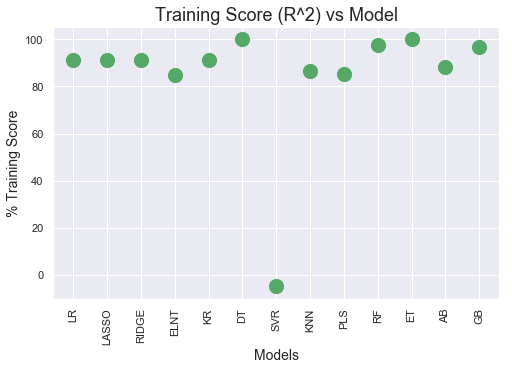

In [45]:
## function to return accuracy by default score method that reurns R^2
def r2_train(model):
    model.fit(train_final, y_train)
    return model.score(train_final, y_train)

## calculating R^2 score for all the models in a for loop
models = [lr, lasso, ridge, elnt, kr, dt, svr, knn, pls, rf, et, ab, gb]
training_score = []
for model in models:
    training_score.append(r2_train(model))

## plotting training accuracy for each model 
train_score = pd.DataFrame(data = training_score, columns = ['Training R^2'])
## naming the index column values according to model type
train_score.index = ['LR', 'LASSO',  'RIDGE', 'ELNT', 'KR', 'DT', 'SVR', 'KNN', 'PLS', 'RF', 'ET', 'AB', 'GB']

train_score = (train_score*100).round(4)
fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(train_score.index, train_score['Training R^2'], s = 200, c='g')
plt.xticks(rotation = 90)
ax.set_xlabel('Models',  fontsize=14)
ax.set_ylabel('% Training Score',  fontsize=14)
ax.set_title('Training Score (R^2) vs Model',  fontsize=18)
plt.show()

In [27]:
train_score.head(2)

,Training R^2
0,0.913071
1,0.913122


https://www.kaggle.com/vikassingh1996/extensive-data-preprocessing-and-modeling

https://www.kaggle.com/eiosifov/top-20-with-data-cleaning-only-elasticnet

https://www.kaggle.com/eiosifov/top-8-without-feature-engineering
